In [1]:
import pandas as pd

ppt = pd.read_csv("NC_precip_daily_2014_2024.csv")
if "time" in ppt.columns:
    ppt.rename(columns={"time": "date"}, inplace=True)

ppt["date"] = pd.to_datetime(ppt["date"])

chl = pd.read_csv("NC_chlorophyll_daily_2014_2024.csv")
chl["date"] = pd.to_datetime(chl["date"])

data = pd.merge(ppt, chl, on="date", how="inner")

data = data.sort_values("date").reset_index(drop=True)
data.head(), data.shape

(        date    precip  chlorophyll
 0 2014-01-03  0.806732     3.115033
 1 2014-01-04  0.000000     2.397363
 2 2014-01-06  9.834883     0.342084
 3 2014-01-07  0.006176     2.153748
 4 2014-01-08  0.743006     1.725000,
 (3216, 3))

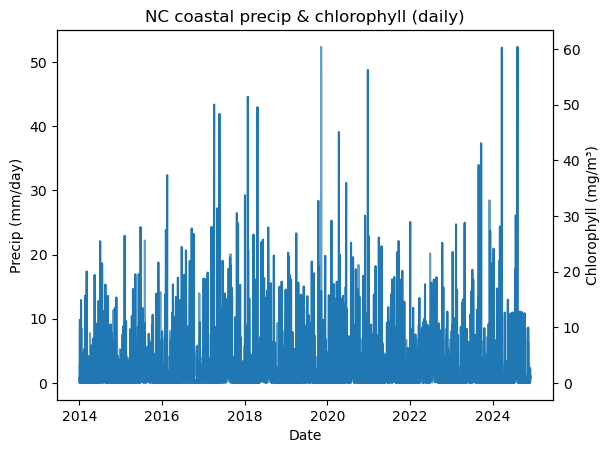

In [2]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(data["date"], data["precip"], label="Precipitation")
ax1.set_ylabel("Precip (mm/day)")

ax2 = ax1.twinx()
ax2.plot(data["date"], data["chlorophyll"], label="Chl-a", alpha=0.7)
ax2.set_ylabel("Chlorophyll (mg/m³)")

ax1.set_xlabel("Date")
plt.title("NC coastal precip & chlorophyll (daily)")
plt.show()

In [3]:
data[["precip", "chlorophyll"]].corr()

,precip,chlorophyll
precip,1.000000,-0.003323
chlorophyll,-0.003323,1.000000


In [12]:
df = data.copy()
df = df.set_index("date")

for lag in [0, 1, 3, 7]:
    df[f"precip_lag{lag}"] = df["precip"].shift(lag)

df["precip_7d_mean"] = df["precip"].rolling(window=7, min_periods=3).mean()

df["target_chl"] = df["chlorophyll"].shift(-7)

df_ml = df.dropna().copy()

df_ml.head()

,precip,chlorophyll,precip_lag0,precip_lag1,precip_lag3,precip_lag7,precip_7d_mean,target_chl
date,,,,,,,,
2014-01-11,8.014994,0.681844,8.014994,1.528795,0.743006,0.806732,2.875408,1.738765
2014-01-12,9.188509,2.014991,9.188509,8.014994,0.000000,0.000000,4.188052,2.030200
2014-01-13,0.000000,2.814532,0.000000,9.188509,1.528795,9.834883,2.783069,5.136821
2014-01-15,0.392399,0.334316,0.392399,0.000000,8.014994,0.006176,2.838243,9.818335
2014-01-16,12.923199,1.584990,12.923199,0.392399,9.188509,0.743006,4.578271,3.470989


In [13]:
X = df_ml.drop(columns=["target_chl"])
y = df_ml["target_chl"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R²:", r2_lr)

Linear Regression RMSE: 1.9881675062427646
Linear Regression R²: 0.0063822837630718166


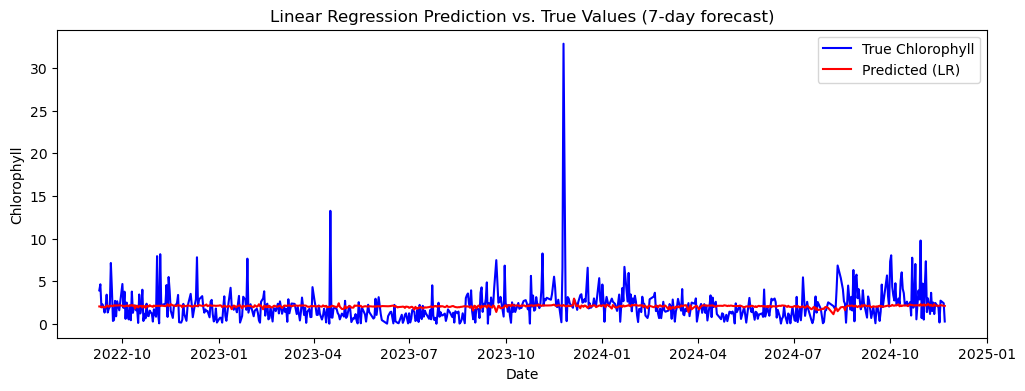

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test, label="True Chlorophyll", color='blue')
plt.plot(y_test.index, y_pred_lr, label="Predicted (LR)", color='red')
plt.legend()
plt.title("Linear Regression Prediction vs. True Values (7-day forecast)")
plt.xlabel("Date")
plt.ylabel("Chlorophyll")
plt.show()

In [16]:
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": lr.coef_
})
coef_df

,feature,coef
0,precip,-0.006976
1,chlorophyll,0.026302
2,precip_lag0,-0.006976
3,precip_lag1,0.000475
4,precip_lag3,-0.007121
5,precip_lag7,-0.008670
6,precip_7d_mean,-0.006891
